In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor
import astropy.units as u
import astropy.coordinates as coord

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from scipy import stats
import matplotlib as mpl

/tmp/ipykernel_77415/2340178517.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [5]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async("""SELECT ra, dec, pmra, pmdec, radial_velocity, parallax, source_id, parallax_error
                                FROM gaiadr3.gaia_source""",
                            dump_to_file=True, output_format='h5')

ModuleNotFoundError: No module named 'astroquery'

In [2]:
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced.hdf5'
with h5py.File(path, 'r') as f:
    print(f.keys())
    ra = f['ra'][:]
    dec = f['dec'][:]
    pmra = f['pmra'][:]
    pmdec = f['pmdec'][:]
    parallax = f['parallax'][:]
    rv = f['radial_velocity'][:]

<KeysViewHDF5 ['Jphi', 'Jr', 'Jz', 'dec', 'feh', 'is_accreted', 'parallax', 'pmdec', 'pmra', 'poe', 'ra', 'radial_velocity', 'source_id']>


In [4]:
ra.shape, dec.shape, pmra.shape, pmdec.shape, parallax.shape, rv.shape

((8593425,), (8593425,), (8593425,), (8593425,), (8593425,), (8593425,))

In [7]:
#User Input
sim = 'DR3_lsr012' #input("DR2 or DR3: ")
dim = '6D' #input("Input how many dimensions are needed: ")
galaxy = 'Gaia' #input("Use m12i or m12f data: ")
transfer = True #bool(input("Transfer learning (True or False): "))
if transfer == True:
    transfer_galaxy = 'm12i' #i nput("Which galaxy parameters for transfer learning: ")

# Training data
if dim == '4D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec']
elif dim == '5D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
elif dim == '6D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '7D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'feh']
elif dim == '9D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz']
elif dim == '10D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz', 'feh']
elif dim == '6D_cyl':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '6D_gal':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
    
y_key = 'is_accreted'

# Directories
# path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/AnankeDR3_data_reduced_m12f_lsr0.hdf5'
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced.hdf5'
out_dir = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim
roc_title = sim + '_' + galaxy + '_' + dim

# Parameters
learning_rate = 1e-3
batch_size = 1024
roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/roc_parameters.hdf5'
training_score_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim + '/training_score.hdf5'

if transfer == True:
    transfer_checkpoint = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim +'/'+ transfer_galaxy +'/'+ dim + '/training_logs/version_0/checkpoints/last.ckpt'

train_parameter_file = out_dir + '/training_parameters.hdf5'
train_log = out_dir + '/training_logs'
checkpoint = train_log + '/version_0/checkpoints/last.ckpt'
    
#Saving roc curves
def save_roc(roc_path, training_score_path, epsilon_i, epsilon_a):
    with h5py.File(roc_path, 'a') as f:
        if dim + '_ep_i' in f.keys():
            del f[dim + '_ep_i']
            del f[dim + '_ep_a']
            f.create_dataset(dim + '_ep_i', data=epsilon_i)
            f.create_dataset(dim + '_ep_a', data=epsilon_a)
        else:
            f.create_dataset(dim + '_ep_i', data=epsilon_i)
            f.create_dataset(dim + '_ep_a', data=epsilon_a)
    with h5py.File(training_score_path, 'w') as f:
            f.create_dataset('score', data=score)
            f.create_dataset('target', data=target)
            f.create_dataset('x_final', data=x_final)
            

data = []
f = h5py.File(path, 'r')

for i in x_keys:
    data.append(f[i][:])
y = f[y_key][:]

# Getting rid of nan values
x = []
if 'Jr' in x_keys:
    Jr = f['Jr'][:]
    mask = (~np.isnan(Jr))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
elif 'radial_velocity' in x_keys:
    rv = f['radial_velocity'][:]
    mask = (~np.isnan(rv))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
else:
    x = data

x = np.vstack(x).T
f.close()

In [37]:
with h5py.File(path, 'r') as f:
    print(f.keys())
    rv = f['radial_velocity'][:]
    is_accreted = f['is_accreted'][:]
    Jr = f['Jr'][:]
    feh = f['feh'][:]

<KeysViewHDF5 ['Jphi', 'Jr', 'Jz', 'dec', 'feh', 'is_accreted', 'parallax', 'pmdec', 'pmra', 'poe', 'ra', 'radial_velocity', 'source_id']>


In [38]:
np.sum(np.isnan(feh))

0

In [9]:
class Model(LightningModule):
                
    def __init__(self, weight, mean_train_x, stdv_train_x, transfer):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(len(x_keys), 100) 
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 2)
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.weight = weight
        self.mean_train_x = mean_train_x
        self.stdv_train_x = stdv_train_x
        if transfer == True:
            self.feature_extractor = Model.load_from_checkpoint(transfer_checkpoint, transfer=False)
            self.feature_extractor.freeze()
    
    def forward(self, x):
        x_out = self.l1(x)
        x_out = torch.relu(x_out)
        x_out = self.l2(x_out)
        x_out = torch.relu(x_out)
        x_out = self.l3(x_out)
        return x_out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_nb):
        train_x, train_y = batch 
        preds = self(train_x)
        loss = F.cross_entropy(preds, train_y, weight = self.weight.to(self.device))
        self.train_acc(preds, train_y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        val_x, val_y = batch
        preds = self(val_x)
        loss = F.cross_entropy(preds, val_y, weight=self.weight.to(self.device))
        self.valid_acc(preds, val_y)
        self.log('val_loss', loss)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [11]:
# if transfer == True:
#     model = Model(weight, mean_train_x, stdv_train_x, transfer=True)
# else:
#     model = Model(weight, mean_train_x, stdv_train_x, transfer=False)
model = Model.load_from_checkpoint(checkpoint)
mean = model.mean_train_x
stdv = model.stdv_train_x
weight = model.weight

test_x = (x - mean) / stdv

test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(y, dtype=torch.long)

test_dataset = list(zip(test_x, test_y))
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [12]:
predict = []
target = []
# x_final = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        yhat = model(x)
        predict.append(yhat.cpu().numpy())
        target.append(y.cpu().numpy())
        # x_final.append(x.cpu().numpy())
predict = np.concatenate(predict)
target = np.concatenate(target)
# x_final = np.concatenate(x_final)

score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))
target_true_mask = (target==True)
target_false_mask = (target==False)

/tmp/ipykernel_75400/2522318344.py:17: RuntimeWarning: overflow encountered in exp
  score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))


In [13]:
predict.shape

(8593425, 2)

In [41]:
score_path = '/ocean/projects/phy210068p/hsu1/Training_results/DR3_lsr012/Gaia/6D_gal/training_score.hdf5'
with h5py.File(score_path, 'r') as f:
    print(f.keys)
    x_final = f['x_final'][:]
    score = f['score'][:]
    target = f['target'][:]

<bound method MappingHDF5.keys of <HDF5 file "training_score.hdf5" (mode r)>>


In [17]:
x_final.shape

(8593425, 6)

In [4]:
ra = x_final[:,0]
dec = x_final[:,1]
pmra = x_final[:,2]
pmdec = x_final[:,3]
parallax = x_final[:,4]
rv = x_final[:,5]

mask0 = (score < 0.765)
mask1 = (score > 0.765)

ra0 = ra[mask0] * u.deg
dec0 = dec[mask0] * u.deg
pmra0 = pmra[mask0] * u.mas / u.yr
pmdec0 = pmdec[mask0] * u.mas / u.yr
parallax0 = parallax[mask0] * u.mas
rv0 = rv[mask0] * u.km / u.s

ra1 = ra[mask1] * u.deg
dec1 = dec[mask1] * u.deg
pmra1 = pmra[mask1] * u.mas / u.yr
pmdec1 = pmdec[mask1] * u.mas / u.yr
parallax1 = parallax[mask1] * u.mas
rv1 = rv[mask1] * u.km / u.s

#Remove nan values in parallax

dist0 = coord.Distance(parallax=parallax0, allow_negative=True)
icrs = coord.ICRS(
    ra=ra0, dec=dec0, distance=dist0, pm_ra_cosdec=pmra0, pm_dec=pmdec0, radial_velocity=rv0)
gal0 = icrs.transform_to(coord.Galactocentric())

x0 = gal0.x.to_value(u.kpc)
y0 = gal0.y.to_value(u.kpc)
z0 = gal0.z.to_value(u.kpc)
vx0 = gal0.v_x.to_value(u.km/u.s)
vy0 = gal0.v_y.to_value(u.km/u.s)
vz0 = gal0.v_z.to_value(u.km/u.s)  

dist1 = coord.Distance(parallax=parallax1, allow_negative=True)
icrs = coord.ICRS(
    ra=ra1, dec=dec1, distance=dist1, pm_ra_cosdec=pmra1, pm_dec=pmdec1, radial_velocity=rv1)
gal1 = icrs.transform_to(coord.Galactocentric())
x1 = gal1.x.to_value(u.kpc)
y1 = gal1.y.to_value(u.kpc)
z1 = gal1.z.to_value(u.kpc)
vx1 = gal1.v_x.to_value(u.km/u.s)
vy1 = gal1.v_y.to_value(u.km/u.s)
vz1 = gal1.v_z.to_value(u.km/u.s)  

vr0 = np.sqrt(vx0**2 + vz0**2)
vr1 = np.sqrt(vx1**2 + vz1**2)

In [5]:
len(x1), np.sum(np.isnan(x1)), len(x0) - np.sum(np.isnan(x0))
x1, x0
#Remove nan

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([        nan,         nan,         nan, ...,         nan,
                nan, -8.31502415]))

In [42]:
mask0 = (score < 0.765)
mask1 = (score > 0.765)
x1 = x_final[:, 0][mask1]
x0 = x_final[:, 0][mask0]
y1 = x_final[:, 1][mask1]
y0 = x_final[:, 1][mask0]
z1 = x_final[:, 2][mask1]
z0 = x_final[:, 2][mask0]
vx1 = x_final[:, 3][mask1]
vx0 = x_final[:, 3][mask0]
vy1 = x_final[:, 4][mask1]
vy0 = x_final[:, 4][mask0]
vz1 = x_final[:, 5][mask1]
vz0 = x_final[:, 5][mask0]
vr0 = np.sqrt(vx0**2 + vz0**2)
vr1 = np.sqrt(vx1**2 + vz1**2)

In [43]:
len(x1), len(x0)

(134453, 8458972)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


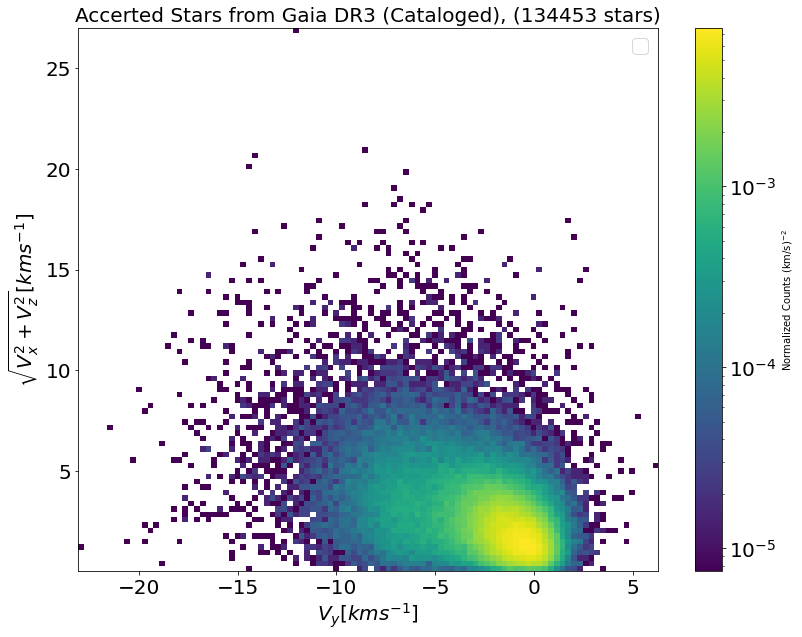

In [46]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=20)
ax.set_title(f'Accerted Stars from Gaia DR3 (Cataloged), ({len(x1)} stars)', fontsize=20)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=20)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy1, vr1, bins=100, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of Accreted Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)